In [220]:
from __future__ import print_function, division
import os
import time
import copy
import math
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from skimage import io, transform
from skimage.transform import resize

import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create dataset class

In [125]:
class PlanktonDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, img_dir, transform=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Select sample
        ID = self.list_IDs[index]
        
        img_name = os.path.join(self.img_dir,ID)
        X = io.imread(img_name)
        
        if self.transform:
            X = self.transform(X)
        
        y = self.labels[ID]

        return X, y, img_name

# Preprocessing
These classes should return the image object.

In [94]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        h, w = image.shape
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img = image[top: top + new_h,
                      left: left + new_w]

        return img
    
class ResizePadded(object):
    """Padd the image so it will be rectangular."""
    
    def __init__(self, order=1):
        self.order = order
    
    def __call__(self, image):
        desired_size = max(image.shape)
        old_size = image.shape

        delta_w = desired_size - old_size[1]
        delta_h = desired_size - old_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        if (top <= 0):
            top = 1
        if (bottom <= 0):
            bottom = 1
        if (left <= 0):
            left = 1
        if (right <= 0):
            right = 1
            
        color = [1, 1, 1]
        new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
        return new_im

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W 
        # torch image: C X H X W
        image = np.expand_dims(image, axis=0)
        return torch.from_numpy(image)

# Create training and validation sets

In [223]:
# Training data
training_data = pd.read_csv('train_onelabel.csv')
IDs_train = training_data['image'].tolist()
random.shuffle(IDs_train)

# Labels of trained images  
labels_train = dict(zip(training_data['image'], training_data['class']))

# Testing data
testing_data = pd.read_csv('sample.csv')
IDs_test = testing_data['image'].tolist()

# Labels of trained images  
labels_test = dict(zip(testing_data['image'], testing_data['class']))

partition = {}
partition['train'] = IDs_train
partition['validation'] = IDs_test

# Create torch datasets

In [233]:
# Parameters
num_epochs = 25
batch_size = 1000
learning_rate = 0.001

resize_scale = 36
crop = 32
padd_size = (400, 400)
num_classes = pd.read_csv('label_map.txt',header=None).shape[0]

In [234]:
# Training
training_set = PlanktonDataset(partition['train'], 
                               labels_train, 
                               img_dir='train_images/',
                               transform=transforms.Compose([Rescale(resize_scale),RandomCrop(crop),ToTensor()]))
training_generator = data.DataLoader(dataset=training_set,
                                           batch_size=batch_size,
                                           shuffle=True)

In [235]:
# Validation
validation_set = PlanktonDataset(partition['validation'], 
                               labels_test, 
                               img_dir='test_images/',
                               transform=transforms.Compose([Rescale(resize_scale),RandomCrop(crop),ToTensor()]))
validation_generator = data.DataLoader(dataset=validation_set,
                                           batch_size=batch_size,
                                           shuffle=True)

# Testing if everything worked so far

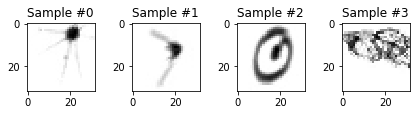

In [242]:
fig = plt.figure()

for i in range(len(training_set)):
    
    sample = training_set[i+10]
    x = sample[0]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    plt.imshow(sample[0][0,:,:],cmap='gray')

    if i == 3:
        #plt.show()
        break 

# Initialise CNN model

In [237]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(8*8*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [238]:
cnn = CNN();
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

# Train CNN

In [239]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels, ids) in enumerate(training_generator):
        images = Variable(images.float())
        labels = Variable(labels)
        #print(labels, ids)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0]);
        #print(i)
        if (i+1) % 5 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(training_generator)/batch_size, loss.data[0]))

Epoch : 1/25, Iter : 5/0,  Loss: 4.0812
Epoch : 1/25, Iter : 10/0,  Loss: 3.7302
Epoch : 1/25, Iter : 15/0,  Loss: 3.5052
Epoch : 1/25, Iter : 20/0,  Loss: 3.3091
Epoch : 1/25, Iter : 25/0,  Loss: 3.0755
Epoch : 2/25, Iter : 5/0,  Loss: 2.9930
Epoch : 2/25, Iter : 10/0,  Loss: 2.9078
Epoch : 2/25, Iter : 15/0,  Loss: 2.9077
Epoch : 2/25, Iter : 20/0,  Loss: 2.7715
Epoch : 2/25, Iter : 25/0,  Loss: 2.7244
Epoch : 3/25, Iter : 5/0,  Loss: 2.6868
Epoch : 3/25, Iter : 10/0,  Loss: 2.6385
Epoch : 3/25, Iter : 15/0,  Loss: 2.6430
Epoch : 3/25, Iter : 20/0,  Loss: 2.5811
Epoch : 3/25, Iter : 25/0,  Loss: 2.5412
Epoch : 4/25, Iter : 5/0,  Loss: 2.5338
Epoch : 4/25, Iter : 10/0,  Loss: 2.4517
Epoch : 4/25, Iter : 15/0,  Loss: 2.4793
Epoch : 4/25, Iter : 20/0,  Loss: 2.4882
Epoch : 4/25, Iter : 25/0,  Loss: 2.4614
Epoch : 5/25, Iter : 5/0,  Loss: 2.3108
Epoch : 5/25, Iter : 10/0,  Loss: 2.2933
Epoch : 5/25, Iter : 15/0,  Loss: 2.1914
Epoch : 5/25, Iter : 20/0,  Loss: 2.2946
Epoch : 5/25, Iter : 

# Predict & save validation set

In [240]:
results = {}

cnn.eval()
correct = 0
total = 0
for images, labels, IDs in validation_generator:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    
    for i in range(len(predicted)):
        results[IDs[i][12:]] = int(predicted[i])

In [241]:
df_results = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_results.columns = ['image', 'class']
df_results.to_csv('results.csv', index=False)